# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch.nn as nn
import torch

In [3]:
from utils import MnistData, Clipper
from models import ModelManager, ModelType
from adversarials import ClassificationAdversarials

In [4]:
import numpy as np
from matplotlib import pyplot as plt

# Settings

In [23]:
linfty_norm_radius = 50 / 255
lone_norm_radius = 100
ltwo_norm_radius = 10

In [6]:
model = ModelManager.get_trained(ModelType.MnistCnnB)

In [7]:
batch_size = 10

In [8]:
data = MnistData(True)

# CW functions

In [18]:
def solve_for_linfty(model, benign_image, label, c_lambda, max_norm):
    step_size = 1e-2
    adv = torch.zeros(benign_image.shape)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    norm_of_diff = lambda x, y: torch.max(torch.abs(x - y))
    adv = adv.unsqueeze(0)
    benign_image = benign_image.unsqueeze(0)
    for _ in range(100):
        adv.requires_grad = True
        if adv.grad is not None:
            adv.grad.zero_()
        loss = norm_of_diff(adv, benign_image) \
            - c_lambda * loss_fn(model(adv), torch.Tensor([label]).type(torch.long))
        loss.backward()
        new_adv = Clipper.clip(
            benign_image,
            (adv - step_size * adv.grad.apply_(lambda x: 1 if x >= 0 else -1)),
            max_norm
        )
        adv = new_adv
    if torch.argmax(model(adv), dim=1)[0] != label or c_lambda > 10:
        return adv.squeeze(0)
    return None

def cw_linfty(model: nn.Module, benign_examples: torch.Tensor, labels: torch.Tensor, max_norm) -> torch.Tensor:
    advs = []
    for i in range(len(benign_examples)):
        print(f'--- {i} ---')
        benign_example, label = benign_examples[i], labels[i]
        adv = None
        c_lambda = 1e-2
        while adv is None:
            adv = solve_for_linfty(model, benign_example, label, c_lambda, max_norm)
            c_lambda *= 1.1
        advs.append(adv)
    return torch.Tensor([adv.tolist() for adv in advs])

In [19]:
def lone_norm(examples: torch.Tensor) -> torch.Tensor:
    return torch.sum(torch.abs(examples))

def solve_for_lone(model, benign_image, label, c_lambda, norm):
    step_size = 1e-2
    adv = torch.zeros(benign_image.shape)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    adv = adv.unsqueeze(0)
    benign_image = benign_image.unsqueeze(0)
    for _ in range(100):
        adv.requires_grad = True
        if adv.grad is not None:
            adv.grad.zero_()
        loss = lone_norm(adv - benign_image) \
            - c_lambda * loss_fn(model(adv), torch.Tensor([label]).type(torch.long))
        loss.backward()
        new_adv = Clipper.clip_with_custom_norm(
            benign_image,
            (adv - step_size * adv.grad.apply_(lambda x: 1 if x >= 0 else -1)),
            lone_norm,
            norm
        )
        adv = new_adv
    if torch.argmax(model(adv), dim=1)[0] != label or c_lambda > 10:
        return adv.squeeze(0)
    return None

def cw_lone(model: nn.Module, benign_examples: torch.Tensor, labels: torch.Tensor, norm) -> torch.Tensor:
    advs = []
    for i in range(len(benign_examples)):
        print(f'--- {i} ---')
        benign_example, label = benign_examples[i], labels[i]
        adv = None
        c_lambda = 1e-2
        while adv is None:
            adv = solve_for_lone(model, benign_example, label, c_lambda, norm)
            c_lambda *= 1.1
        advs.append(adv)
    return torch.Tensor([adv.tolist() for adv in advs])

In [20]:
def ltwo_norm(examples: torch.Tensor) -> torch.Tensor:
    return torch.sum(torch.abs(examples) ** 2) ** (1 / 2)

def solve_for_ltwo(model, benign_image, label, c_lambda, norm):
    step_size = 1e-2
    adv = torch.zeros(benign_image.shape)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    adv = adv.unsqueeze(0)
    benign_image = benign_image.unsqueeze(0)
    for _ in range(100):
        adv.requires_grad = True
        if adv.grad is not None:
            adv.grad.zero_()
        loss = ltwo_norm(adv - benign_image) \
            - c_lambda * loss_fn(model(adv), torch.Tensor([label]).type(torch.long))
        loss.backward()
        new_adv = Clipper.clip_with_custom_norm(
            benign_image,
            (adv - step_size * adv.grad.apply_(lambda x: 1 if x >= 0 else -1)),
            ltwo_norm,
            norm
        )
        adv = new_adv
    if torch.argmax(model(adv), dim=1)[0] != label or c_lambda > 10:
        return adv.squeeze(0)
    return None

def cw_ltwo(model: nn.Module, benign_examples: torch.Tensor, labels: torch.Tensor, norm) -> torch.Tensor:
    advs = []
    for i in range(len(benign_examples)):
        print(f'--- {i} ---')
        benign_example, label = benign_examples[i], labels[i]
        adv = None
        c_lambda = 1e-2
        while adv is None:
            adv = solve_for_ltwo(model, benign_example, label, c_lambda, norm)
            c_lambda *= 1.1
        advs.append(adv)
    return torch.Tensor([adv.tolist() for adv in advs])

# Generation

In [12]:
benign_examples, labels = data.choose_first_well_classified(batch_size, model)

In [24]:
cw_linfty_examples = cw_linfty(model, benign_examples, labels, linfty_norm_radius)
cw_lone_examples = cw_lone(model, benign_examples, labels, lone_norm_radius)
cw_ltwo_examples = cw_ltwo(model, benign_examples, labels, ltwo_norm_radius)

--- 0 ---
--- 1 ---
--- 2 ---
--- 3 ---
--- 4 ---
--- 5 ---
--- 6 ---
--- 7 ---
--- 8 ---
--- 9 ---


cw_linfty: 8
cw_lone: 4
cw_ltwo: 10


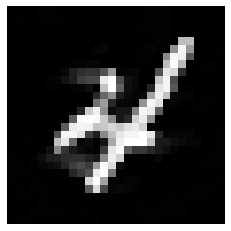

In [25]:
# Save'em all
for i in range(batch_size):
    example = np.array(benign_examples[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\CW_NORMS\\benign_{i}.png", bbox_inches="tight", pad_inches=0)
    
    example = np.array(cw_linfty_examples[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\CW_NORMS\\cw_linfty_{i}.png", bbox_inches="tight", pad_inches=0)
    
    example = np.array(cw_lone_examples[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\CW_NORMS\\cw_lone_{i}.png", bbox_inches="tight", pad_inches=0)
    
    example = np.array(cw_ltwo_examples[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\CW_NORMS\\cw_ltwo_{i}.png", bbox_inches="tight", pad_inches=0)

cw_linfty_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, cw_linfty_examples)
print(f'cw_linfty: {len(cw_linfty_adversarials)}')

cw_lone_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, cw_lone_examples)
print(f'cw_lone: {len(cw_lone_adversarials)}')

cw_ltwo_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, cw_ltwo_examples)
print(f'cw_ltwo: {len(cw_ltwo_adversarials)}')